In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re 
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
# from jupyter_dash import JupyterDash
# from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 

import colorcet as cc


/tmp/ipykernel_27740/258682039.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    #dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=False,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')


    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal', range=[0,1])
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        #plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        plot2 = dataframe.hist(column=['correct.'], ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2[0].set_title('')
        plot2[0].set_xlabel('correctness')
        plot2[0].set_ylabel('')

    fig.tight_layout()
#     fig_save = fig.get_figure()
#     fig_save.savefig(args.base_path+'datamap.pdf') 

In [4]:
base_path = '../../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
#scatter_it(df, hue_metric ='correct.',  title='', model='LXMERT', show_hist=True)

In [ ]:
# load training dataset and assign answer type, question type, question length, and score columns
# iterate over and assign finer grained question types
# plot wrt to each attribute 

In [5]:
train_dataset = json.load(open('../../../../data/vqa/train.json'))
train_dataset.extend(json.load(open('../../../../data/vqa/nominival.json')))

In [6]:
df.head()

,confidence,variability,correctness,question_id,Predictions,Question,Target,Image ID,Image URL
0,0.182518,0.159355,0.35,570738000,"[blue, yankees, 5:18, black, blue team, bears, cubs, braves, rays, colorado, red sox]",[What team is at bat?],"[dodgers, indians, blue team, angels]",[COCO_train2014_000000570738],http://images.cocodataset.org/train2014/COCO_train2014_000000570738.jpg
1,0.041185,0.112215,0.15,201460003,"[12:35, 2:05, 3:15, 12:55, 10:30, 1, 3:30, 6:00, 5:15, 12:00, 4:00, 5:18, 2:40]",[What time is on the clock?],"[12:40, 8:00]",[COCO_train2014_000000201460],http://images.cocodataset.org/train2014/COCO_train2014_000000201460.jpg
2,0.048267,0.131839,0.20,259733004,"[light, wire, shelf, yes, handle, above, bar, glass, dry, clean, rack, 5:18]",[How does the toilet paper stay dry?],[glass],[COCO_train2014_000000259733],http://images.cocodataset.org/train2014/COCO_train2014_000000259733.jpg
3,0.387907,0.197260,0.50,365999001,"[2, 4, 1, 6, 3, 5:18]",[How many tennis balls do you see?],[3],[COCO_train2014_000000365999],http://images.cocodataset.org/train2014/COCO_train2014_000000365999.jpg
4,0.416278,0.294295,0.70,253915000,"[5:18, pirate, police, man, casual]",[What is he dressed as?],[pirate],[COCO_train2014_000000253915],http://images.cocodataset.org/train2014/COCO_train2014_000000253915.jpg


In [7]:
quesid_2datum = {}
for i in train_dataset:
    quesid_2datum[i['question_id']] = i

In [8]:
datamap_quesids = df['question_id'].tolist()
answer_types = []
labels = []
question_types = []
question_length = []
score_tf = [] #true or false values on whether this instance contains a target with score of 1.0 or not

# does one particualr label always get assigned the same low score --> look at score distribution of each class
# its important to include all classes but how should they be represented: should we only use those examples in the category that have a high score
    # while still maintaining the class distribution ... or is it really necessary to have so many confidently predicted class predictions 


for ques_id in datamap_quesids:
    datum = quesid_2datum[ques_id]
    answer_types.append(datum['answer_type'])
    labels.append(datum['label'])
    question_types.append(datum['question_type'])
    question_length.append(len(datum['sent'].split()))
    label_vals = datum['label'].values()
    if 1 in label_vals or 1.0 in label_vals:
        score_tf.append(True)
    else:
        score_tf.append(False)
        
    
    
    

In [9]:
df['answer_types'] = answer_types
df['labels'] = labels
df['question_types'] = question_types
df['question_lengths'] = question_length
df['score_tf'] = score_tf

In [13]:
len(df['question_lengths'].unique())

22

In [18]:
def scatter_it_attribute(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False, attribute='answer_type'):
    # Subsample data to plot, so the plot is not too busy.
    #dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
#     print(sampled_question_ids_path)

#     with open(sampled_question_ids_path, 'rb') as f:
#         sampled_ids = pickle.load(f)

    if attribute == 'answer_type':

        grouped = df.groupby(df.answer_types)

        df1 = grouped.get_group("other")
        df2 = grouped.get_group("number")
        df3 = grouped.get_group("yes/no")
    

        concatenated = pd.concat([df1.assign(dataset='other'), df2.assign(dataset='number'), df3.assign(dataset='yes/no')])
        palette = ['lightblue', 'darkblue', 'red']
    elif attribute == 'scores':

        grouped = df.groupby(df.score_tf)

        df1 = grouped.get_group(True)
        df2 = grouped.get_group(False)    

        concatenated = pd.concat([df1.assign(dataset='True'), df2.assign(dataset='False')])
        palette = ['lightblue', 'darkblue']
    elif attribute == 'question_types':
        grouped = df.groupby(df.question_types)
        list_of_groups = grouped.groups.keys()
        df_concat = []
        for i in list_of_groups:
            df1 = grouped.get_group(i)
            df_concat.append(df1.assign(dataset=i))
        concatenated = pd.concat(df_concat)
        palette = sns.color_palette(cc.glasbey, n_colors=65)
    elif attribute == 'question_length':
        grouped = df.groupby(df.question_lengths)
        list_of_groups = grouped.groups.keys()
        df_concat = []
        for i in list_of_groups:
            df1 = grouped.get_group(i)
            df_concat.append(df1.assign(dataset=i))
        concatenated = pd.concat(df_concat)
        palette = sns.color_palette(cc.glasbey, n_colors=22)
        
    else:
        print("attribute not in dataframe")


    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=concatenated,
                           palette=palette,
                           hue='dataset',
                           style='dataset',
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=False,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    plot.set_title(f"{model}-{title} Data Map", fontsize=17)

    fig.tight_layout()
    fig.show()
    #fig_save = fig.get_figure()
    #sample_name = os.path.basename(os.path.splitext(sampled_question_ids_path)[0])
    #fig_save.savefig(args.base_path+sample_name+'_datamap.pdf') 

/tmp/ipykernel_27740/4293524071.py:106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/jaspreet/.conda/envs/lxmert/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


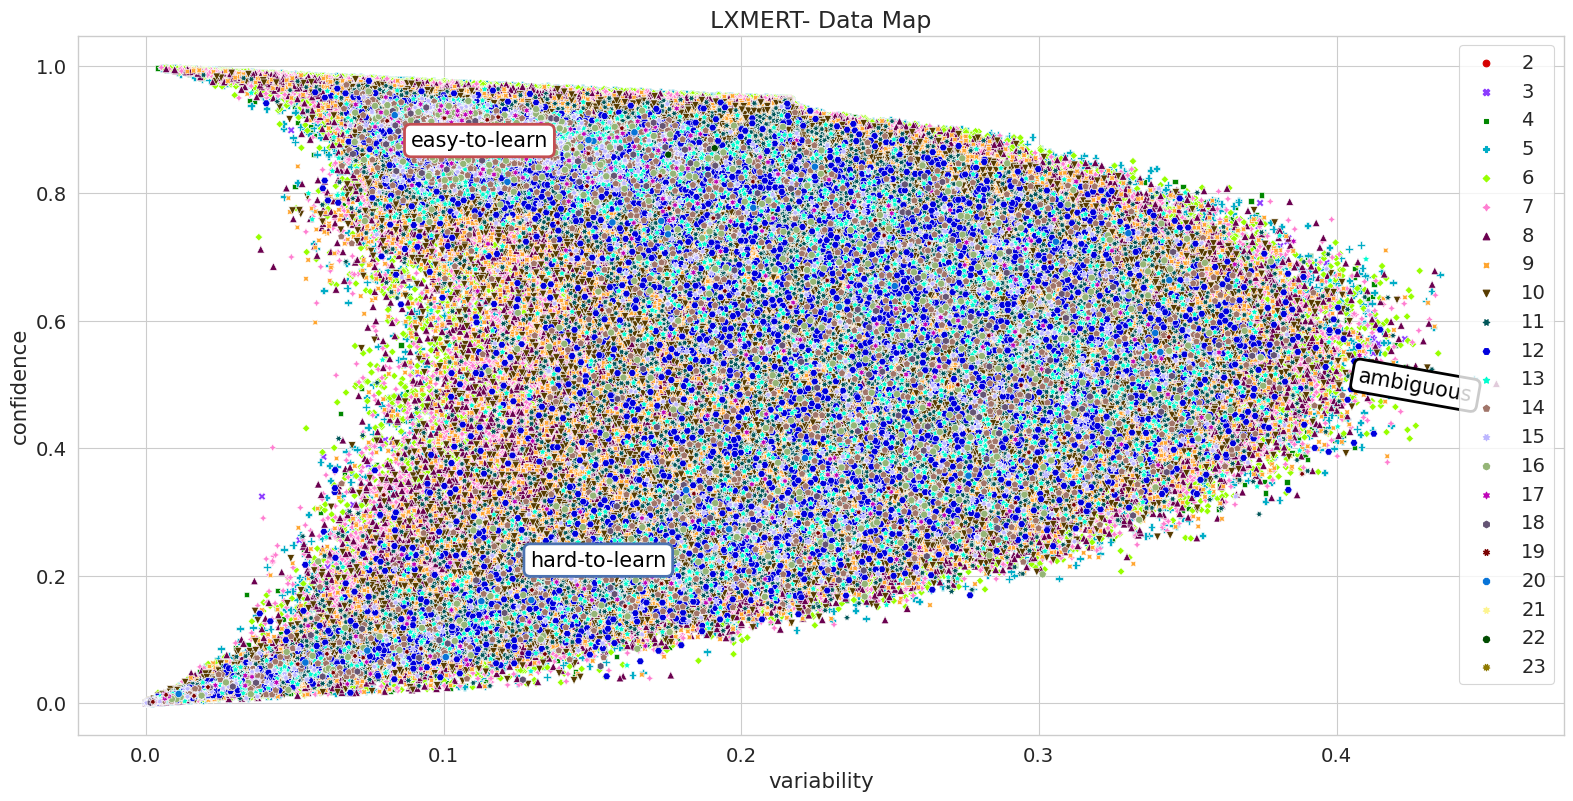

In [19]:
scatter_it_attribute(df, hue_metric ='correct.',  title='', model='LXMERT', show_hist=True, attribute='question_length')